In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
!cp -r '/content/drive/MyDrive/full_3' 'document'

In [3]:
!pip install keras
!pip install tensorflow

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [4]:
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Conv2D, BatchNormalization, MaxPool2D, Dropout, Flatten, MaxPooling2D
from sklearn.feature_extraction.text import TfidfVectorizer
from tensorflow.keras.optimizers import SGD
from keras.utils.np_utils import to_categorical
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers
import numpy as np 
import os

from tensorflow.keras.applications import ResNet50
#from tensorflow.keras.applications.ResNet50 import ResNet50

In [5]:
path_documents = 'document'
lista_subfolders = os.listdir(path_documents)

dataset_dict = {}

dataset_dict['filename'] = []
dataset_dict['label'] = []

for folder in lista_subfolders:
  lista_imagens = os.listdir(path_documents+'/'+folder)

  for img_file in lista_imagens:
    dataset_dict['filename'].append(folder+'/'+img_file)
    dataset_dict['label'].append(folder)


In [6]:
df = pd.DataFrame(dataset_dict,columns=['filename','label'])

In [7]:
X=df['filename'].values
y=df['label'].values

In [8]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
X_valid, X_test, y_valid, y_test = train_test_split(X_test, y_test, test_size=0.6, random_state=42)

crição de logits

In [9]:
from keras.utils.np_utils import to_categorical

train_labels = pd.Categorical(y_train)
valid_labels = pd.Categorical(y_valid)
test_labels = pd.Categorical(y_test)


y_train_int = train_labels.codes
y_valid_int = valid_labels.codes
y_test_int = test_labels.codes


y_train_logits = to_categorical(y_train_int)
y_valid_logits = to_categorical(y_valid_int)
y_test_logits = to_categorical(y_test_int)

In [10]:
lista_train = []
for i in range(0,len(X_train)):
  lista_train.append([X_train[i],y_train[i]])
  
lista_valid = []
for i in range(0,len(X_valid)):
  lista_valid.append([X_valid[i],y_valid[i]])
  
lista_test = []
for i in range(0,len(X_test)):
  lista_test.append([X_test[i],y_test[i]])
  


In [11]:
df_train = pd.DataFrame(lista_train, columns=['filename','label'])
df_valid = pd.DataFrame(lista_valid, columns=['filename','label'])
df_test = pd.DataFrame(lista_test, columns=['filename','label'])

In [12]:
# train_datagen = ImageDataGenerator(rescale =  1.255,
#                                    featurewise_center=True,
#                                    featurewise_std_normalization=True,
#                                    rotation_range=20,
#                                    width_shift_range=0.2,
#                                    height_shift_range=0.2,
#                                    horizontal_flip=True)

datagen = ImageDataGenerator(rescale=1./255)

train_generator = datagen.flow_from_dataframe(df_train,
                                              directory=path_documents,
                                              x_col='filename', y_col='label',
                                              class_mode = 'categorical',
                                              shufle=True)

valid_generator = datagen.flow_from_dataframe(df_valid,
                                              directory=path_documents,
                                              x_col='filename', y_col='label',
                                              class_mode = 'categorical',
                                              shufle=True)

test_generator = datagen.flow_from_dataframe(df_test,
                                             directory=path_documents,
                                             x_col='filename', y_col='label',
                                             class_mode = 'categorical',
                                             shufle=True)

Found 2072 validated image filenames belonging to 3 classes.
Found 356 validated image filenames belonging to 3 classes.
Found 533 validated image filenames belonging to 3 classes.


/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 3 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)
/usr/local/lib/python3.7/dist-packages/keras_preprocessing/image/dataframe_iterator.py:282: UserWarning: Found 1 invalid image filename(s) in x_col="filename". These filename(s) will be ignored.
  .format(n_invalid, x_col)


In [13]:
num_classes=3

In [14]:
model = Sequential()

model.add(layers.experimental.preprocessing.Resizing(224,224,interpolation="bilinear",input_shape=(224,224,3)))
model.add(Conv2D(96,(11,11), strides=(4,4)))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(256,(5,5), strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))
model.add(BatchNormalization())

model.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(384,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(BatchNormalization())

model.add(Conv2D(256,(3,3), strides=(1,1),padding="same"))
model.add(Activation("relu"))
model.add(MaxPooling2D((3, 3),strides=(2,2)))
model.add(BatchNormalization())

model.add(Flatten())
model.add(Dense(4096))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(4096))
model.add(Activation("relu"))
model.add(Dropout(0.5))

model.add(Dense(num_classes))
model.add(Activation("softmax"))

In [15]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resizing (Resizing)         (None, 224, 224, 3)       0         
                                                                 
 conv2d (Conv2D)             (None, 54, 54, 96)        34944     
                                                                 
 activation (Activation)     (None, 54, 54, 96)        0         
                                                                 
 max_pooling2d (MaxPooling2D  (None, 26, 26, 96)       0         
 )                                                               
                                                                 
 batch_normalization (BatchN  (None, 26, 26, 96)       384       
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 26, 26, 256)       6

In [16]:
sgd = SGD(lr=0.0001)

model.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [17]:
history = model.fit(train_generator,
          epochs=20,
          batch_size=16,
          validation_data=valid_generator)

Epoch 1/20
65/65 [==============================] - 36s 339ms/step - loss: 1.0946 - accuracy: 0.5299 - val_loss: 1.1443 - val_accuracy: 0.3399
Epoch 2/20
65/65 [==============================] - 16s 253ms/step - loss: 0.7090 - accuracy: 0.7153 - val_loss: 1.3171 - val_accuracy: 0.3399
Epoch 3/20
65/65 [==============================] - 13s 198ms/step - loss: 0.6277 - accuracy: 0.7519 - val_loss: 1.5734 - val_accuracy: 0.3399
Epoch 4/20
65/65 [==============================] - 11s 170ms/step - loss: 0.5863 - accuracy: 0.7756 - val_loss: 1.6754 - val_accuracy: 0.3399
Epoch 5/20
65/65 [==============================] - 10s 155ms/step - loss: 0.5316 - accuracy: 0.8012 - val_loss: 1.4478 - val_accuracy: 0.3427
Epoch 6/20
65/65 [==============================] - 10s 156ms/step - loss: 0.5154 - accuracy: 0.7997 - val_loss: 1.3655 - val_accuracy: 0.3680
Epoch 7/20
65/65 [==============================] - 10s 157ms/step - loss: 0.5260 - accuracy: 0.8055 - val_loss: 0.9100 - val_accuracy: 0.5506

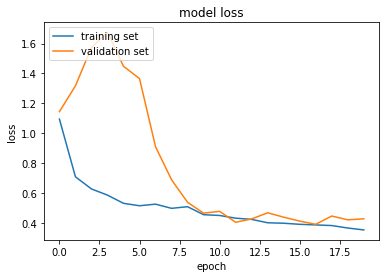

In [18]:
history_fine = model.history
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [19]:
y_prob = model.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [20]:
y_prob

array([[0.00413785, 0.99341327, 0.00244888],
       [0.0029019 , 0.9943389 , 0.00275923],
       [0.8258261 , 0.10088709, 0.07328676],
       ...,
       [0.05352325, 0.00703565, 0.93944114],
       [0.12705828, 0.0913548 , 0.7815869 ],
       [0.8991341 , 0.0079252 , 0.09294076]], dtype=float32)

In [21]:
y_test = test_generator.classes

In [22]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.34      0.38      0.36       184
           1       0.35      0.39      0.37       170
           2       0.32      0.24      0.27       179

    accuracy                           0.34       533
   macro avg       0.33      0.34      0.33       533
weighted avg       0.33      0.34      0.33       533



# ResNet50 sem pré-treinamento

In [23]:
model_resnet = Sequential()

model_resnet_not_pt = ResNet50(input_shape=(224,224,3),
                             include_top=False,
                             pooling='avg',
                             weights=None,
                             classes=num_classes)

model_resnet.add(model_resnet_not_pt)
model_resnet.add(Flatten())
model_resnet.add(Dense(4096))
model_resnet.add(Activation("relu"))
model_resnet.add(Dropout(0.5))

model_resnet.add(Dense(num_classes))
model_resnet.add(Activation("softmax"))



In [24]:
model_resnet.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_1 (Flatten)         (None, 2048)              0         
                                                                 
 dense_3 (Dense)             (None, 4096)              8392704   
                                                                 
 activation_8 (Activation)   (None, 4096)              0         
                                                                 
 dropout_2 (Dropout)         (None, 4096)              0         
                                                                 
 dense_4 (Dense)             (None, 3)                 12291     
                                                                 
 activation_9 (Activation)   (None, 3)                

In [25]:
sgd = SGD(lr=0.0001)

model_resnet.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [26]:
history = model_resnet.fit(train_generator,
          epochs=20,
          batch_size=16,
          validation_data=valid_generator)

Epoch 1/20
65/65 [==============================] - 40s 513ms/step - loss: 1.1090 - accuracy: 0.4358 - val_loss: 1.1073 - val_accuracy: 0.3399
Epoch 2/20
65/65 [==============================] - 29s 450ms/step - loss: 0.8812 - accuracy: 0.5989 - val_loss: 1.1928 - val_accuracy: 0.3399
Epoch 3/20
65/65 [==============================] - 29s 447ms/step - loss: 0.8052 - accuracy: 0.6404 - val_loss: 1.3498 - val_accuracy: 0.3399
Epoch 4/20
65/65 [==============================] - 29s 450ms/step - loss: 0.7754 - accuracy: 0.6569 - val_loss: 1.4642 - val_accuracy: 0.3399
Epoch 5/20
65/65 [==============================] - 29s 449ms/step - loss: 0.7332 - accuracy: 0.6877 - val_loss: 1.5262 - val_accuracy: 0.3399
Epoch 6/20
65/65 [==============================] - 29s 449ms/step - loss: 0.7034 - accuracy: 0.6979 - val_loss: 1.4289 - val_accuracy: 0.3399
Epoch 7/20
65/65 [==============================] - 29s 448ms/step - loss: 0.6690 - accuracy: 0.7148 - val_loss: 1.2357 - val_accuracy: 0.3455

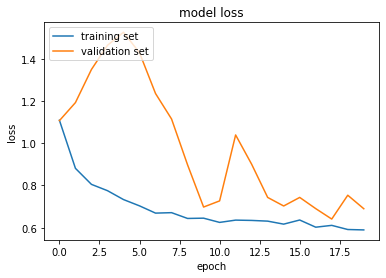

In [27]:
history_fine = model_resnet.history
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [28]:
y_prob = model_resnet.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [29]:
y_prob

array([[0.22585869, 0.05659266, 0.7175486 ],
       [0.15472116, 0.12863217, 0.7166467 ],
       [0.12274604, 0.5668788 , 0.31037518],
       ...,
       [0.14130954, 0.48988727, 0.3688031 ],
       [0.1179031 , 0.6063861 , 0.27571076],
       [0.11843698, 0.26820856, 0.61335444]], dtype=float32)

In [30]:
y_test = test_generator.classes

In [31]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.37      0.26      0.31       184
           1       0.29      0.25      0.26       170
           2       0.31      0.44      0.36       179

    accuracy                           0.32       533
   macro avg       0.32      0.32      0.31       533
weighted avg       0.32      0.32      0.31       533



# ResNet50 com pré-treinamento de pesos imaget

In [32]:
model_resnet_pt = Sequential()

pre_trained_model = ResNet50(input_shape=(224,224,3),
                             include_top=False,
                             pooling='avg',
                             weights="imagenet",
                             classes=num_classes)

for layer in pre_trained_model.layers:
  layer.trainable = False

model_resnet_pt.add(pre_trained_model)
model_resnet_pt.add(Flatten())
model_resnet_pt.add(Dense(4096))
model_resnet_pt.add(Activation("relu"))
model_resnet_pt.add(Dropout(0.5))

model_resnet_pt.add(Dense(num_classes))
model_resnet_pt.add(Activation("softmax"))

In [33]:
model_resnet_pt.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 resnet50 (Functional)       (None, 2048)              23587712  
                                                                 
 flatten_2 (Flatten)         (None, 2048)              0         
                                                                 
 dense_5 (Dense)             (None, 4096)              8392704   
                                                                 
 activation_10 (Activation)  (None, 4096)              0         
                                                                 
 dropout_3 (Dropout)         (None, 4096)              0         
                                                                 
 dense_6 (Dense)             (None, 3)                 12291     
                                                                 
 activation_11 (Activation)  (None, 3)                

In [34]:
sgd = SGD(lr=0.0001)

model_resnet_pt.compile(optimizer=sgd,loss='categorical_crossentropy',metrics=['accuracy'])



/usr/local/lib/python3.7/dist-packages/keras/optimizer_v2/gradient_descent.py:102: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(SGD, self).__init__(name, **kwargs)


In [35]:
history = model_resnet_pt.fit(train_generator,
          epochs=20,
          batch_size=16,
          validation_data=valid_generator)

Epoch 1/20
65/65 [==============================] - 16s 201ms/step - loss: 1.1460 - accuracy: 0.3769 - val_loss: 1.0141 - val_accuracy: 0.5674
Epoch 2/20
65/65 [==============================] - 11s 175ms/step - loss: 1.1228 - accuracy: 0.4146 - val_loss: 0.9705 - val_accuracy: 0.6517
Epoch 3/20
65/65 [==============================] - 11s 175ms/step - loss: 1.0447 - accuracy: 0.4706 - val_loss: 0.9330 - val_accuracy: 0.7163
Epoch 4/20
65/65 [==============================] - 11s 173ms/step - loss: 1.0104 - accuracy: 0.4889 - val_loss: 0.9034 - val_accuracy: 0.6910
Epoch 5/20
65/65 [==============================] - 11s 174ms/step - loss: 0.9927 - accuracy: 0.5053 - val_loss: 0.8752 - val_accuracy: 0.7584
Epoch 6/20
65/65 [==============================] - 12s 185ms/step - loss: 0.9784 - accuracy: 0.5323 - val_loss: 0.8541 - val_accuracy: 0.7669
Epoch 7/20
65/65 [==============================] - 11s 173ms/step - loss: 0.9360 - accuracy: 0.5473 - val_loss: 0.8346 - val_accuracy: 0.7612

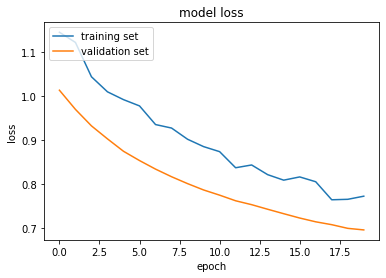

In [36]:
history_fine = model_resnet_pt.history
loss = history_fine.history['loss']
val_loss = history_fine.history['val_loss']

plt.plot(history_fine.history['loss'])
plt.plot(history_fine.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['training set','validation set'], loc='upper left')
plt.show()

In [37]:
y_prob = model_resnet_pt.predict(test_generator)
y_pred = np.argmax(y_prob,axis=1)

In [38]:
y_prob

array([[0.24984297, 0.26031107, 0.48984596],
       [0.49486715, 0.26920256, 0.2359303 ],
       [0.13804692, 0.6093214 , 0.25263175],
       ...,
       [0.24535862, 0.41742066, 0.33722076],
       [0.14945218, 0.5841459 , 0.26640195],
       [0.20426022, 0.4020179 , 0.39372194]], dtype=float32)

In [39]:
y_test = test_generator.classes

In [40]:
from sklearn.metrics import classification_report
print(classification_report(y_test,y_pred))

              precision    recall  f1-score   support

           0       0.34      0.33      0.34       184
           1       0.29      0.38      0.33       170
           2       0.29      0.22      0.25       179

    accuracy                           0.31       533
   macro avg       0.31      0.31      0.31       533
weighted avg       0.31      0.31      0.31       533



#Em uma análise comparativa rápida, podemos notar que infelizmente os f1-scores dos modelos ainda ficaram baixos, indicando um alta possibilidade de overffiting.

f1-score  AlexNet:
*  0.36    
*  0.37    
*  0.27   

f1-score Resnet50 sem pré treinamento:
*  0.31       
*  0.26   
*  0.36
   
f1-score Resnet50 COM pré treinamento:
*  0.34      
*  0.33   
*  0.25



# Extraindo texto das imagens

testes com pymupdf:

In [41]:
#!pip install pymupdf

In [42]:
#import fitz

In [43]:
# #path_documents = 'document'
# #lista_subfolders = os.listdir(path_documents)

# #dataset_dict = {}

# #dataset_dict['filename'] = []
# #dataset_dict['label'] = []

# # for folder in lista_subfolders:
# #   lista_imagens = os.listdir(path_documents+'/'+folder)
# #   for img_file in lista_imagens:
# #     doc = fitz.open(path_documents+'/'+folder+'/'+img_file)
# #     for page in doc:  # iterate the document pages
# #       text = page.get_text().encode("utf8")  # get plain text (is in UTF-8)
# #       print(text)

# for folder in lista_subfolders:
#   lista_imagens = os.listdir(path_documents+'/'+folder)
#   for img_file in lista_imagens:
#     doc = fitz.open(path_documents+'/'+folder+'/'+img_file)
#     for page_index in range(len(doc)):
        
#         # get the page itself
#         page = doc[page_index]
#         image_list = page.getImageList()
          
#         # printing number of images found in this page
#         if image_list:
#             print(f"[+] Found a total of {len(image_list)} images in page {page_index}")
#         else:
#             print("[!] No images found on page", page_index)
#         for image_index, img in enumerate(page.getImageList(), start=1):
            
#             # get the XREF of the image
#             xref = img[0]
              
#             # extract the image bytes
#             base_image = doc.extractImage(xref)
#             image_bytes = base_image["image"]
              
#             # get the image extension
#             image_ext = base_image["ext"]
#             print(image_ext)

testes com keras-ocr:

In [44]:
# !pip install keras-ocr

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [45]:
# import keras_ocr 
# pipeline = keras_ocr.pipeline.Pipeline()

Looking for /root/.keras-ocr/craft_mlt_25k.h5
Looking for /root/.keras-ocr/crnn_kurapan.h5


In [46]:
# path_documents = 'drive/MyDrive/full_3/advertisement'
# lista_subfolders = os.listdir(path_documents)

# print(lista_subfolders)

# lista_path=[]

# # for folder in lista_subfolders:
# #   lista_imagens = os.listdir(path_documents+'/'+folder)
# #   for img_file in lista_imagens:
# #     lista_path.append(path_documents+'/'+folder+'/'+img_file)

# #images = [keras_ocr.tools.read(url) for url in lista_subfolders]
# images = [keras_ocr.tools.read(path_documents+'/'+url) for url in lista_subfolders]


['71388738.tif', '01792718.tif', '2072280165.tif', '83847108a.tif', 'tob00301.79.tif', '91654603_4604.tif', '2084510910_0912.tif', '7794.tif', '89912652.tif', '01339594.tif', '71895001.tif', '2063810365.tif', '1002762055.tif', '92203104.tif', '0000897105.tif', '1002762820.tif', '882450.tif', '2045483235.tif', '2085146174.tif', '2023702624.tif', '4090.tif', '502593031.tif', '2061000197.tif', '0208.tif', '2061012521.tif', '3188.tif', '0330.tif', '2084427752_7753.tif', '71172802.tif', '0071.tif', '502594234.tif', '03079144.tif', '2072942359.tif', '1002762737.tif', '5400.tif', '502597050.tif', '03028833.tif', '9302.tif', '93366243.tif', '502592933.tif', 'tim00787.81.tif', '2070738231.tif', '1002763063.tif', 'okl00123.62.tif', '501948072.tif', '501948873_501948974.tif', '2070718725.tif', '82262421_2422.tif', '2084412659_2660.tif', '2071466675.tif', '2070712178_2179.tif', '507806716.tif', '506728188.tif', '502473366.tif', '514087932.tif', '2021255635.tif', '2058502189.tif', '2084420118_0119.

In [ ]:
# prediction_groups = pipeline.recognize(images)

In [ ]:
# predicted_image_1 = prediction_groups[0]
# for text, box in predicted_image_1:
#   print(text)  

Devido a problemas com leitura do PymuPDf e ram com o kerasOCR, infelizmente não fui capaz de finalizar a tarefa, desculpe